In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix,roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, SelectKBest
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import pickle

In [186]:
# Load data
file_path = 'SDN Dataset/dataset_sdn.csv'
df = pd.read_csv(file_path)


In [187]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Display the number of missing values for each column
print(missing_values)

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64


In [188]:
# Fill missing values without using inplace
df['rx_kbps'] = df['rx_kbps'].fillna(df['rx_kbps'].mean())
df['tot_kbps'] = df['tot_kbps'].fillna(df['tot_kbps'].mean())

# Verify that there are no missing values left
missing_values_after = df.isnull().sum()
print("Missing values in each column after imputation:\n", missing_values_after[missing_values_after > 0])

Missing values in each column after imputation:
 Series([], dtype: int64)


In [189]:
# Encode categorical variables
categorical_columns = ['src', 'dst', 'Protocol']
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Scale numerical features
numerical_columns = ['pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows', 'packetins', 
                     'pktperflow', 'byteperflow', 'pktrate', 'Pairflow', 'port_no', 'tx_bytes', 
                     'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [190]:
# Define features and target
X = df.drop(columns=['label'])  # Features
y = df['label']

In [191]:
mutual_info = mutual_info_classif(X, y)
mi_scores = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

# Display top 10 features based on mutual information
print("Top 10 features based on Information Gain:")
print(mi_scores.head(10))

chi2_scores, p_values = chi2(X.abs(), y)  # Taking absolute to ensure no negative values
chi2_scores_series = pd.Series(chi2_scores, index=X.columns).sort_values(ascending=False)

# Display top 10 features based on Chi-square scores
print("Top 10 features based on Chi-square scores:")
print(chi2_scores_series.head(10))

# Apply the F-test (ANOVA) on the features
f_scores, p_values = f_classif(X, y)
f_scores_series = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)

# Display top 10 features based on F-test scores
print("Top 10 features based on F-test scores:")
print(f_scores_series.head(10))

Top 10 features based on Information Gain:
bytecount      0.634171
pktcount       0.616179
byteperflow    0.559092
pktperflow     0.543062
pktrate        0.384731
dt             0.284489
tot_dur        0.266982
tx_bytes       0.209372
dur            0.197527
packetins      0.193822
dtype: float64
Top 10 features based on Chi-square scores:
dt             1.012680e+07
Protocol       5.358869e+03
src            5.259520e+03
pktrate        3.177747e+03
pktperflow     3.173045e+03
byteperflow    1.916822e+03
tot_dur        9.886131e+02
dur            9.884112e+02
packetins      5.321364e+02
bytecount      4.443218e+02
dtype: float64
Top 10 features based on F-test scores:
pktcount      20099.877787
bytecount      8704.145723
Protocol       7462.735187
flows          3581.738163
src            1287.406795
dt             1280.987007
tot_dur        1022.083847
dur            1021.848426
pktrate         814.572509
pktperflow      810.959673
dtype: float64


In [192]:
# Get the top 10 features for each method
top_features_mi = mi_scores.head(10).index
top_features_chi2 = chi2_scores_series.head(10).index
top_features_f_test = f_scores_series.head(10).index
print("\nSelected Features Comparison:")
print("Mutual Information Top Features:", list(top_features_mi))
print("Chi-Square Top Features:", list(top_features_chi2))
print("F-Test Top Features:", list(top_features_f_test))


Selected Features Comparison:
Mutual Information Top Features: ['bytecount', 'pktcount', 'byteperflow', 'pktperflow', 'pktrate', 'dt', 'tot_dur', 'tx_bytes', 'dur', 'packetins']
Chi-Square Top Features: ['dt', 'Protocol', 'src', 'pktrate', 'pktperflow', 'byteperflow', 'tot_dur', 'dur', 'packetins', 'bytecount']
F-Test Top Features: ['pktcount', 'bytecount', 'Protocol', 'flows', 'src', 'dt', 'tot_dur', 'dur', 'pktrate', 'pktperflow']


In [193]:
# Feature selection methods
selection_methods = {
    'Mutual Information': top_features_mi,
    'Chi-Square': top_features_chi2,
    'F-Test': top_features_f_test
}

# Function to apply class balancing techniques
def apply_class_balancing(X, y, technique):
    if technique == 'Random Oversampling':
        ros = RandomOverSampler(random_state=42)
        return ros.fit_resample(X, y)
    elif technique == 'Random Undersampling':
        rus = RandomUnderSampler(random_state=42)
        return rus.fit_resample(X, y)
    elif technique == 'SMOTE':
        smote = SMOTE(random_state=42)
        return smote.fit_resample(X, y)
    else:
        raise ValueError("Unknown technique")

# Apply each balancing technique
techniques = ['Random Oversampling', 'Random Undersampling', 'SMOTE']
balanced_data = {}

for technique in techniques:
    X_bal, y_bal = apply_class_balancing(X, y, technique)
    balanced_data[technique] = (X_bal, y_bal)
    
    print(f"\nClass distribution after {technique}:")
    print(pd.Series(y_bal).value_counts())


Class distribution after Random Oversampling:
label
0    63561
1    63561
Name: count, dtype: int64

Class distribution after Random Undersampling:
label
0    40784
1    40784
Name: count, dtype: int64

Class distribution after SMOTE:
label
0    63561
1    63561
Name: count, dtype: int64


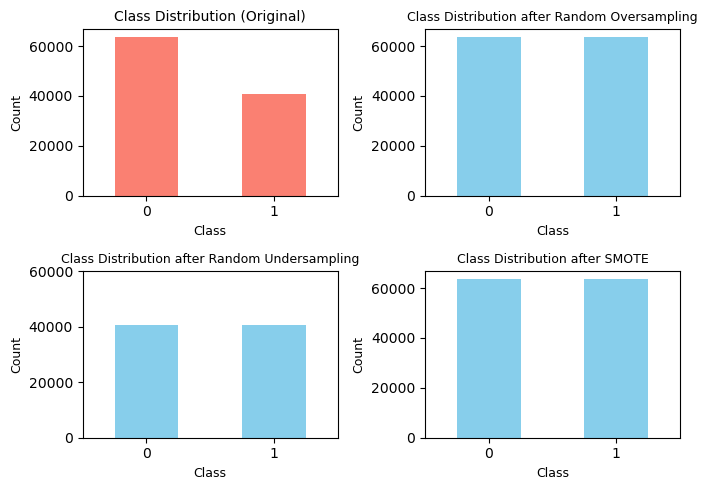

In [194]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting function
def plot_class_distribution(X, y, balanced_data, filename='class_distribution.png'):
    plt.figure(figsize=(7, 5))
    
    # Plotting the original class distribution
    plt.subplot(2, 2, 1)
    pd.Series(y).value_counts().plot(kind='bar', color='salmon')
    plt.title('Class Distribution (Original)',fontsize=10)
    plt.xlabel('Class',fontsize=9)
    plt.ylabel('Count',fontsize=9)
    plt.xticks(rotation=0)
    
    # Plotting class distributions after each balancing technique
    techniques = list(balanced_data.keys())
    
    for i, (technique, (X_bal, y_bal)) in enumerate(balanced_data.items(), start=2):
        plt.subplot(2, 2, i)
        counts = pd.Series(y_bal).value_counts()
        if technique == 'Random Undersampling':
            counts.plot(kind='bar', color='skyblue')
            plt.ylim(0, 60000)  # Set y-axis limit to 60,000
        else:
            counts.plot(kind='bar', color='skyblue')
        plt.title(f'Class Distribution after {technique}',fontsize=9)
        plt.xlabel('Class',fontsize=9)
        plt.ylabel('Count',fontsize=9)
        plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Call the plotting function with the original and balanced data
plot_class_distribution(X, y, balanced_data)

In [196]:
# Define a function to train and evaluate models
def train_and_evaluate(X_train, y_train, X_test, y_test):
    models = {
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC()
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = (model, report)
    
    return results

In [197]:
# Dictionary to store results
evaluation_results = {}

In [198]:
# # Function to evaluate models and store confusion matrices and ROC data
# def evaluate_models(selection_name, technique, X_train, X_test, y_train, y_test, results):
#     # Ensure the structure for selection_name and technique exists in evaluation_results
#     if selection_name not in evaluation_results:
#         evaluation_results[selection_name] = {}
    
#     if technique not in evaluation_results[selection_name]:
#         evaluation_results[selection_name][technique] = {}
    
#     for model_name, (model, report) in results.items():
#         print(f"\nModel: {model_name}")
#         print(f"Precision: {report['1']['precision']}")
#         print(f"Recall: {report['1']['recall']}")
#         print(f"F1-score: {report['1']['f1-score']}")
        
#         # Confusion matrix
#         y_pred = model.predict(X_test)
#         cm = confusion_matrix(y_test, y_pred)
        
#         # ROC Curve and AUC Score
#         if hasattr(model, "predict_proba"):  # Ensure the model has a predict_proba method
#             y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
#         else:
#             y_proba = model.decision_function(X_test)  # For models like SVM
        
#         fpr, tpr, _ = roc_curve(y_test, y_proba)
#         roc_auc = roc_auc_score(y_test, y_proba)
        
#         # Initialize a list for the model results if it doesn't exist
#         if model_name not in evaluation_results[selection_name][technique]:
#             evaluation_results[selection_name][technique][model_name] = []
        
#         # Append the results to the model's list
#         evaluation_results[selection_name][technique][model_name].append({
#             'confusion_matrix': cm,
#             'roc_curve': {
#                 'fpr': fpr,
#                 'tpr': tpr,
#                 'auc': roc_auc
#             },
#             'precision': report['1']['precision'],
#             'recall': report['1']['recall'],
#             'f1_score': report['1']['f1-score']
#         })


# Function to evaluate models and store confusion matrices, ROC data, and learning curves
def evaluate_models(selection_name, technique, X_train, X_test, y_train, y_test, results, cv=5):
    # Ensure the structure for selection_name and technique exists in evaluation_results
    if selection_name not in evaluation_results:
        evaluation_results[selection_name] = {}
    
    if technique not in evaluation_results[selection_name]:
        evaluation_results[selection_name][technique] = {}
    
    for model_name, (model, report) in results.items():
        print(f"\nModel: {model_name}")
        print(f"Precision: {report['1']['precision']}")
        print(f"Recall: {report['1']['recall']}")
        print(f"F1-score: {report['1']['f1-score']}")
        
        # Confusion matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        # ROC Curve and AUC Score
        if hasattr(model, "predict_proba"):  # Ensure the model has a predict_proba method
            y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        else:
            y_proba = model.decision_function(X_test)  # For models like SVM
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # Learning curve
        train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

        # Initialize a list for the model results if it doesn't exist
        if model_name not in evaluation_results[selection_name][technique]:
            evaluation_results[selection_name][technique][model_name] = []
        
        # Append the results to the model's list
        evaluation_results[selection_name][technique][model_name].append({
            'confusion_matrix': cm,
            'roc_curve': {
                'fpr': fpr,
                'tpr': tpr,
                'auc': roc_auc
            },
            'learning_curve': {
                'train_sizes': train_sizes,
                'train_scores': train_scores,
                'test_scores': test_scores
            },
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1_score': report['1']['f1-score']
        })



In [199]:
# Function to split data and call the evaluation
def split_and_train(selection_name, technique, selected_features, X_bal, y_bal):
    X_selected = X_bal[selected_features]  # Use selected features for the model
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_bal, test_size=0.3, random_state=42)
    
    # Train and evaluate models
    results = train_and_evaluate(X_train, y_train, X_test, y_test)
    
    # Call model evaluation function
    evaluate_models(selection_name, technique, X_train, X_test, y_train, y_test, results)



In [200]:
# Function to evaluate a single feature selection method with different balancing techniques
def evaluate_single_feature_selection(selection_name, selected_features, balanced_data, techniques):
    print(f"\nEvaluating for feature selection: {selection_name}")
    
    for technique in techniques:
        print(f"Using class balancing technique: {technique}")
        X_bal, y_bal = balanced_data[technique]
        
        # Call split_and_train to evaluate the models
        split_and_train(selection_name, technique, selected_features, X_bal, y_bal)


In [201]:
selected_features = selection_methods["Mutual Information"]
evaluate_single_feature_selection('Mutual Information', selected_features, balanced_data, techniques)


Evaluating for feature selection: Mutual Information
Using class balancing technique: Random Oversampling

Model: KNN
Precision: 0.9943693101089301
Recall: 0.9972556470339877
F1-score: 0.9958103870780743

Model: Decision Tree
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Model: Random Forest
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Model: SVM
Precision: 0.6316356650892564
Recall: 0.7114735064386742
F1-score: 0.6691817031098757


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Using class balancing technique: Random Undersampling

Model: KNN
Precision: 0.9920091324200914
Recall: 0.9950924259774252
F1-score: 0.9935483870967742

Model: Decision Tree
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Model: Random Forest
Precision: 1.0
Recall: 1.0
F1-score: 1.0


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Model: SVM
Precision: 0.6311463693539165
Recall: 0.7223131032226403
F1-score: 0.6736593180257838


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Using class balancing technique: SMOTE

Model: KNN
Precision: 0.9942667788764991
Recall: 0.9976250791640279
F1-score: 0.9959430979978925

Model: Decision Tree
Precision: 1.0
Recall: 0.9995777918513827
F1-score: 0.9997888513513513

Model: Random Forest
Precision: 1.0
Recall: 0.9997361199071142
F1-score: 0.9998680425430841

Model: SVM
Precision: 0.6323769535805925
Recall: 0.715378931813384
F1-score: 0.6713220909788773


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [202]:
# Function to draw ROC curves for a feature selection method
def draw_roc_curves_for_method(selection_name):
    # Check if the selection method exists
    if selection_name not in evaluation_results:
        print(f"No evaluation results for feature selection method: {selection_name}")
        return
    
    # Define colors and line styles
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    linestyles = ['-', '--', '-.', ':']
    
    # Extract class balancing techniques and models
    techniques = evaluation_results[selection_name].keys()
    models_set = set(model_name for technique in techniques 
                     for model_name in evaluation_results[selection_name][technique])
    
    # Set up the plot grid based on the number of models
    num_models = len(models_set)
    num_cols = 2
    num_rows = (num_models + num_cols - 1) // num_cols
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 5 * num_rows))
    axes = axes.flatten()
    fig.suptitle(f'ROC Curves for Feature Selection: {selection_name}', fontsize=16)
    
    # Loop through each ML model (one subplot per model)
    for i, model_name in enumerate(models_set):
        ax = axes[i]
        
        # Plot ROC curves for each class balancing technique for the current feature selection method and ML model
        for j, technique in enumerate(techniques):
            if model_name in evaluation_results[selection_name][technique]:
                roc_data = evaluation_results[selection_name][technique][model_name][0]['roc_curve']
                color = colors[j % len(colors)]
                linestyle = linestyles[j % len(linestyles)]
                
                # Plot the ROC curve
                ax.plot(roc_data['fpr'], roc_data['tpr'], 
                        label=f"{technique} (AUC = {roc_data['auc']:.5f})", 
                        linestyle=linestyle, 
                        color=color)

        # Plot diagonal line for random classifier
        ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

        # Set title, labels, and grid for each ML model
        ax.set_title(f'{model_name}', fontsize=12)
        ax.set_xlabel('False Positive Rate', fontsize=10)
        ax.set_ylabel('True Positive Rate', fontsize=10)
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=8)
    
    # Hide any extra subplots that aren't being used
    for i in range(num_models, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout for the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'roc_curves_feature_{selection_name}.png', dpi=300)
    plt.show()

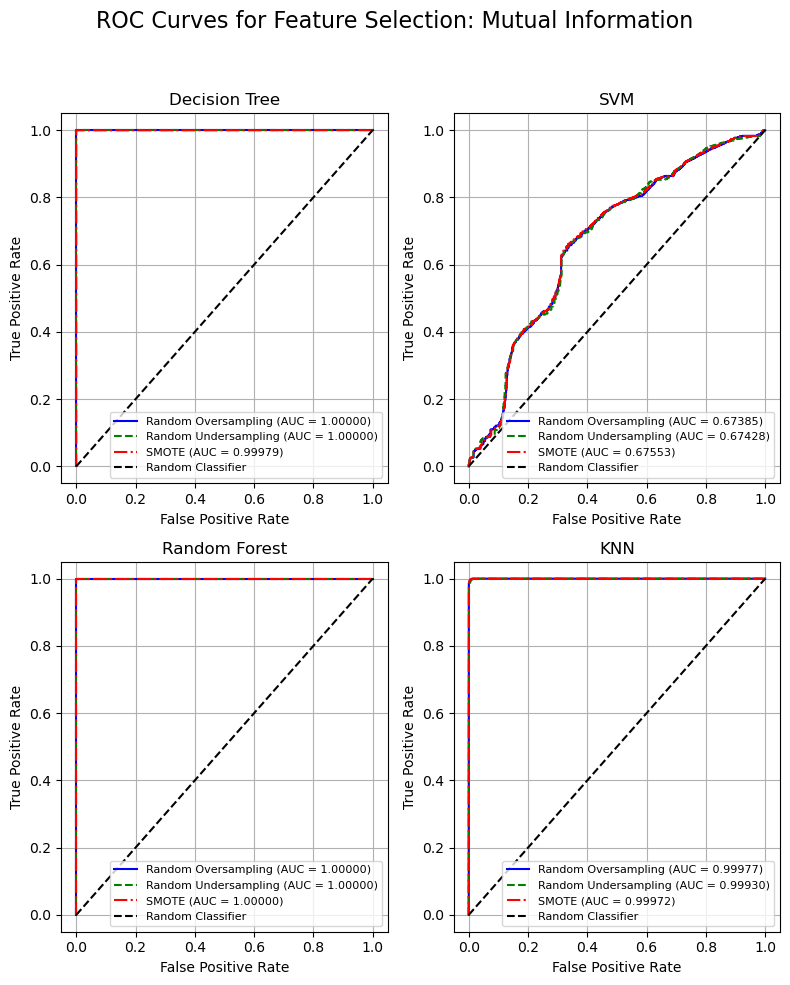

In [203]:
draw_roc_curves_for_method('Mutual Information')

In [204]:
def plot_confusion_matrices(selection_name):
    # Check if the selection method exists
    if selection_name not in evaluation_results:
        print(f"No evaluation results for feature selection method: {selection_name}")
        return
    
    # Extract class balancing techniques and models
    techniques = list(evaluation_results[selection_name].keys())
    models_set = set(model_name for technique in techniques 
                     for model_name in evaluation_results[selection_name][technique])

    # Create a figure with subplots
    fig, axes = plt.subplots(len(techniques), len(models_set), figsize=(10, 6))
    axes = axes.flatten()

    ax_index = 0
    for technique in techniques:
        for model_name in models_set:
            ax = axes[ax_index]
            if model_name in evaluation_results[selection_name][technique]:
                # Access the confusion matrix from the list
                cm_data = evaluation_results[selection_name][technique][model_name][0]['confusion_matrix']

                # Create a ConfusionMatrixDisplay object
                disp = ConfusionMatrixDisplay(confusion_matrix=cm_data)
                # Plot the confusion matrix on the specified axis
                disp.plot(ax=ax, colorbar=False, cmap='Blues')  # Set the color map

                # Set the tick labels font size
                ax.set_title(f'{technique} + {model_name}', fontsize=8)
                ax.xaxis.set_tick_params(labelsize=8)
                ax.yaxis.set_tick_params(labelsize=8)
                ax.set_xlabel('Predicted Label', fontsize=8)
                ax.set_ylabel('True Label', fontsize=8)
            else:
                ax.set_visible(False)  # Hide empty subplots
            
            ax_index += 1  # Increment the axis index

    # Set a single title for the entire figure
    fig.suptitle(f'Confusion Matrices for {selection_name} Feature Selection', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.savefig(f'confusion-matrices_{selection_name}.png', dpi=300)
    plt.show()


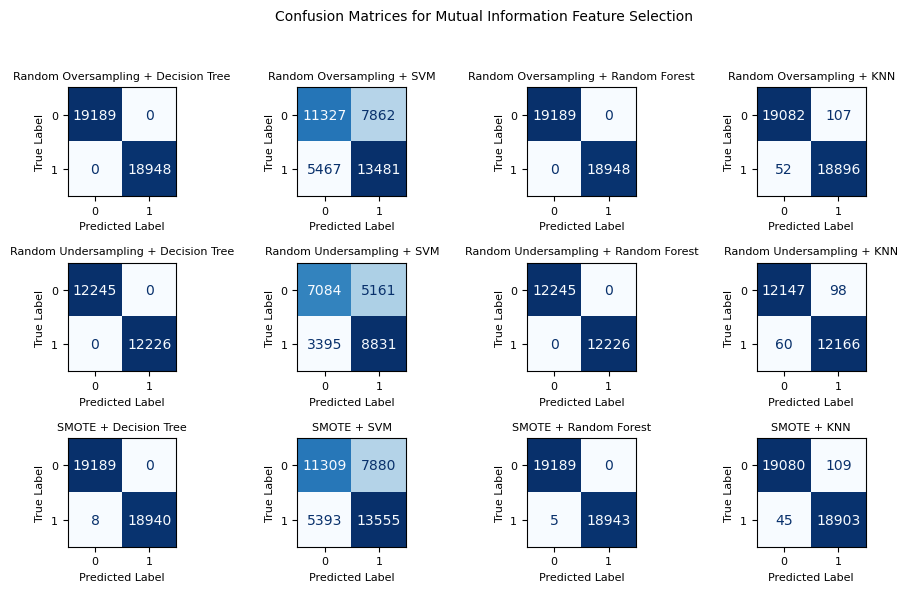

In [205]:
# Call the function to draw confusion matrices for the selected feature selection method
plot_confusion_matrices('Mutual Information')

In [206]:
def plot_learning_curves(selection_name):
    # Check if the selection method exists
    if selection_name not in evaluation_results:
        print(f"No evaluation results for feature selection method: {selection_name}")
        return
    
    # Extract class balancing techniques and models
    techniques = list(evaluation_results[selection_name].keys())
    models_set = set(model_name for technique in techniques 
                     for model_name in evaluation_results[selection_name][technique])

    # Create a figure with subplots
    fig, axes = plt.subplots(len(techniques), len(models_set), figsize=(10, 6))
    axes = axes.flatten()

    ax_index = 0
    for technique in techniques:
        for model_name in models_set:
            ax = axes[ax_index]
            if model_name in evaluation_results[selection_name][technique]:
                # Access the learning curve data (train_scores and test_scores) from the results
                learning_data = evaluation_results[selection_name][technique][model_name][0]['learning_curve']
                train_sizes = learning_data['train_sizes']
                train_scores = learning_data['train_scores']
                test_scores = learning_data['test_scores']

                # Plot the learning curve on the specified axis
                ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
                ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")

                # Set the title, labels, and legends
                ax.set_title(f'{technique} - {model_name}', fontsize=8)
                ax.set_xlabel('Training Examples', fontsize=8)
                ax.set_ylabel('Score', fontsize=8)
                ax.xaxis.set_tick_params(labelsize=8)
                ax.yaxis.set_tick_params(labelsize=8)
                ax.legend(loc="best", fontsize=8)
            else:
                ax.set_visible(False)  # Hide empty subplots
            
            ax_index += 1  # Increment the axis index

    # Set a single title for the entire figure
    fig.suptitle(f'Learning Curves for {selection_name} Feature Selection', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'learning-curves_{selection_name}.png', dpi=300)
    plt.show()


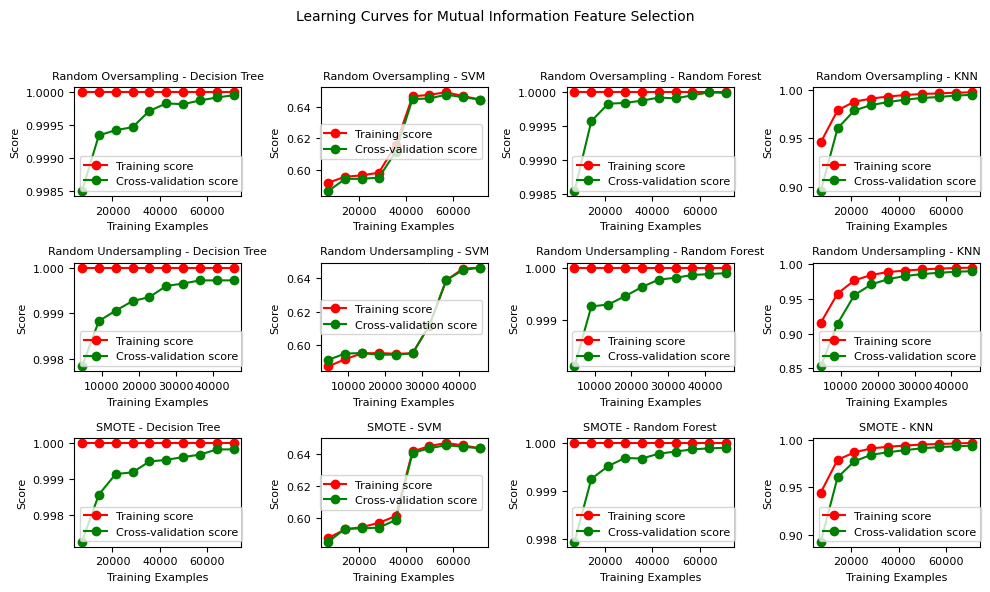

In [208]:
plot_learning_curves('Mutual Information')

In [209]:
selected_features = selection_methods["Chi-Square"]
evaluate_single_feature_selection('Chi-Square', selected_features, balanced_data, techniques)


Evaluating for feature selection: Chi-Square
Using class balancing technique: Random Oversampling

Model: KNN
Precision: 0.9929248991143022
Recall: 0.9998944479628457
F1-score: 0.9963974861290068

Model: Decision Tree
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Model: Random Forest
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Model: SVM
Precision: 0.6316356650892564
Recall: 0.7114735064386742
F1-score: 0.6691817031098757


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Using class balancing technique: Random Undersampling

Model: KNN
Precision: 0.9881019830028328
Recall: 0.9985277277932275
F1-score: 0.9932874984744314

Model: Decision Tree
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Model: Random Forest
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Model: SVM
Precision: 0.6311463693539165
Recall: 0.7223131032226403
F1-score: 0.6736593180257838


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Using class balancing technique: SMOTE

Model: KNN
Precision: 0.992918961447679
Recall: 0.9990500316656111
F1-score: 0.9959750611632863

Model: Decision Tree
Precision: 1.0
Recall: 0.9995250158328056
F1-score: 0.9997624515005147

Model: Random Forest
Precision: 1.0
Recall: 0.9998416719442685
F1-score: 0.9999208297046948

Model: SVM
Precision: 0.6323769535805925
Recall: 0.715378931813384
F1-score: 0.6713220909788773


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


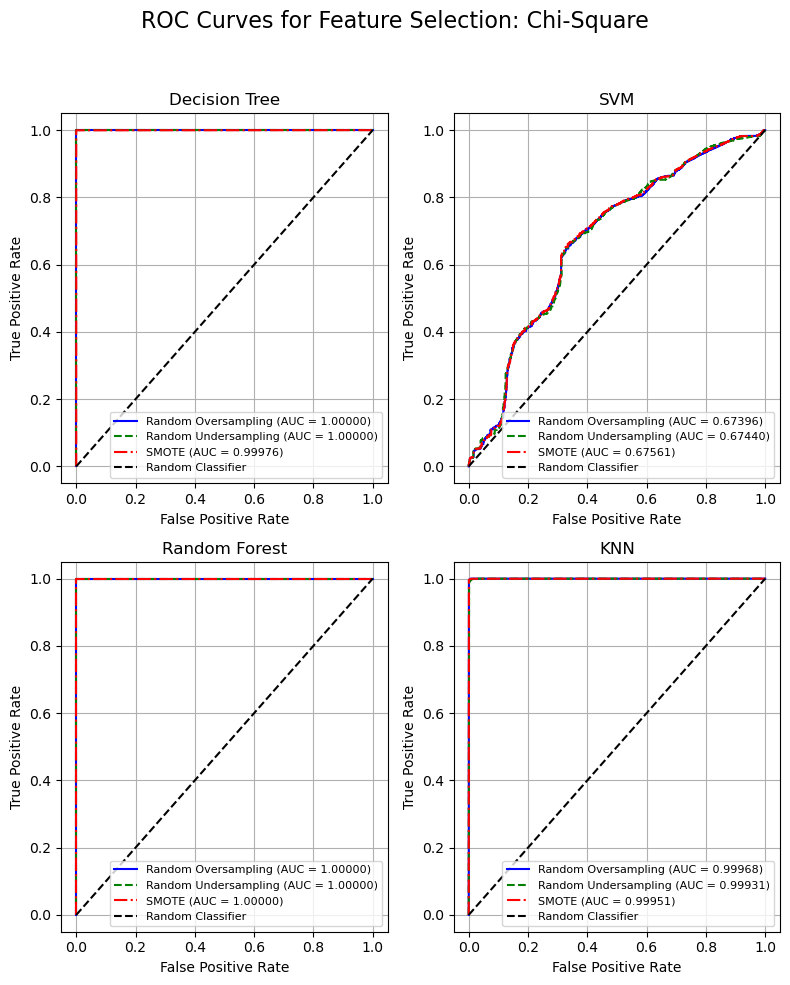

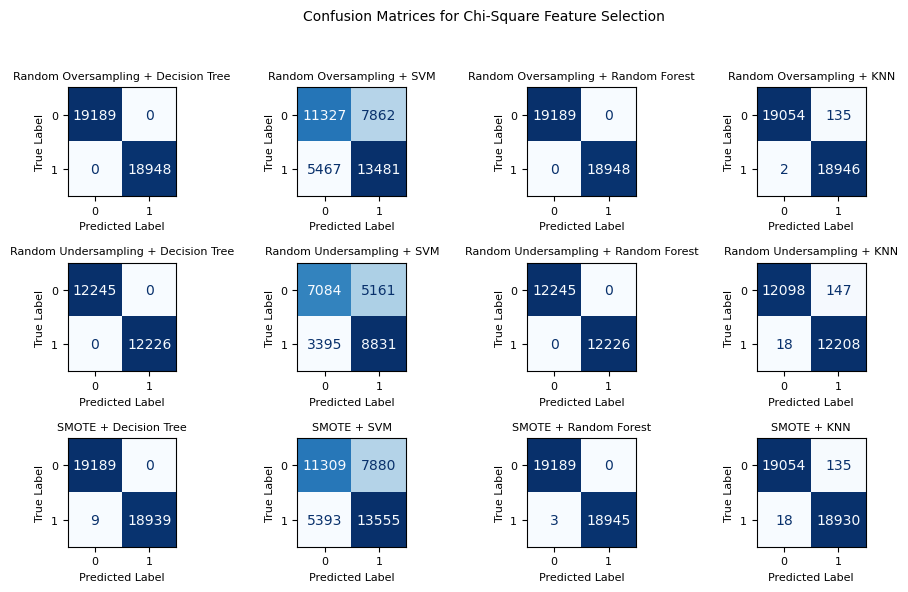

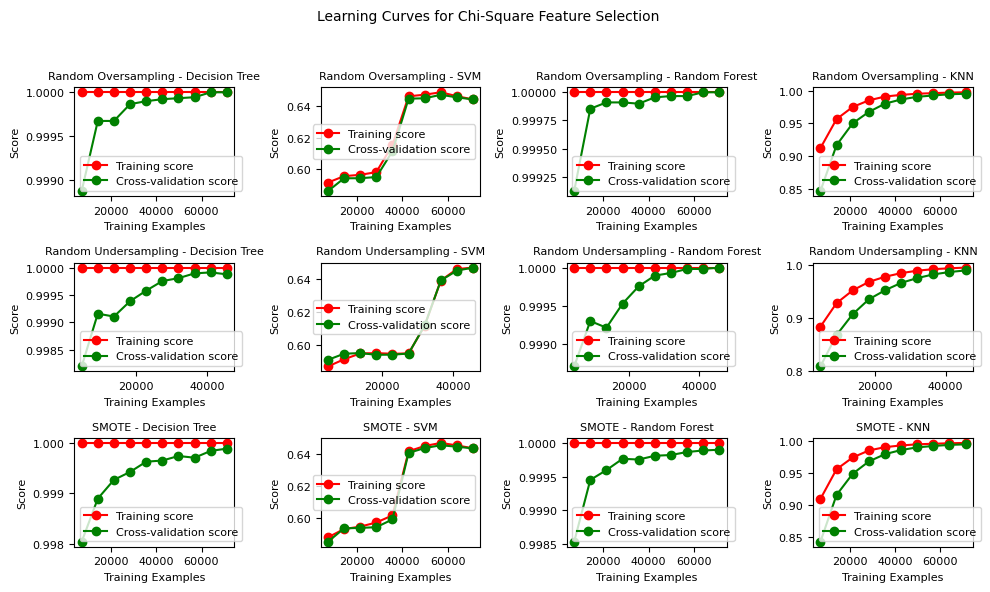

In [211]:
draw_roc_curves_for_method("Chi-Square")
# Call the function to draw confusion matrices for the Chi-square feature selection method
plot_confusion_matrices('Chi-Square')
plot_learning_curves('Chi-Square')

In [212]:
selected_features = selection_methods["F-Test"]
evaluate_single_feature_selection('F-Test', selected_features, balanced_data, techniques)


Evaluating for feature selection: F-Test
Using class balancing technique: Random Oversampling

Model: KNN
Precision: 0.9948488830486203
Recall: 0.9988917036098797
F1-score: 0.9968661944012851

Model: Decision Tree
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Model: Random Forest
Precision: 0.9998416970080735
Recall: 1.0
F1-score: 0.9999208422385815

Model: SVM
Precision: 0.6316356650892564
Recall: 0.7114735064386742
F1-score: 0.6691817031098757


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Using class balancing technique: Random Undersampling

Model: KNN
Precision: 0.9881262199089135
Recall: 0.9937837395714052
F1-score: 0.9909469048201615

Model: Decision Tree
Precision: 0.9997546814948074
Recall: 1.0
F1-score: 0.9998773257002658

Model: Random Forest
Precision: 1.0
Recall: 1.0
F1-score: 1.0


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Model: SVM
Precision: 0.6311463693539165
Recall: 0.7223131032226403
F1-score: 0.6736593180257838


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Using class balancing technique: SMOTE

Model: KNN
Precision: 0.9948958114081246
Recall: 0.9978361832383364
F1-score: 0.9963638279932546

Model: Decision Tree
Precision: 1.0
Recall: 0.9992611357399198
F1-score: 0.9996304313394224

Model: Random Forest
Precision: 1.0
Recall: 0.9994722398142284
F1-score: 0.9997360502560313

Model: SVM
Precision: 0.6323769535805925
Recall: 0.715378931813384
F1-score: 0.6713220909788773


/Users/macbook/Library/mljar-studio/jlab_server/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


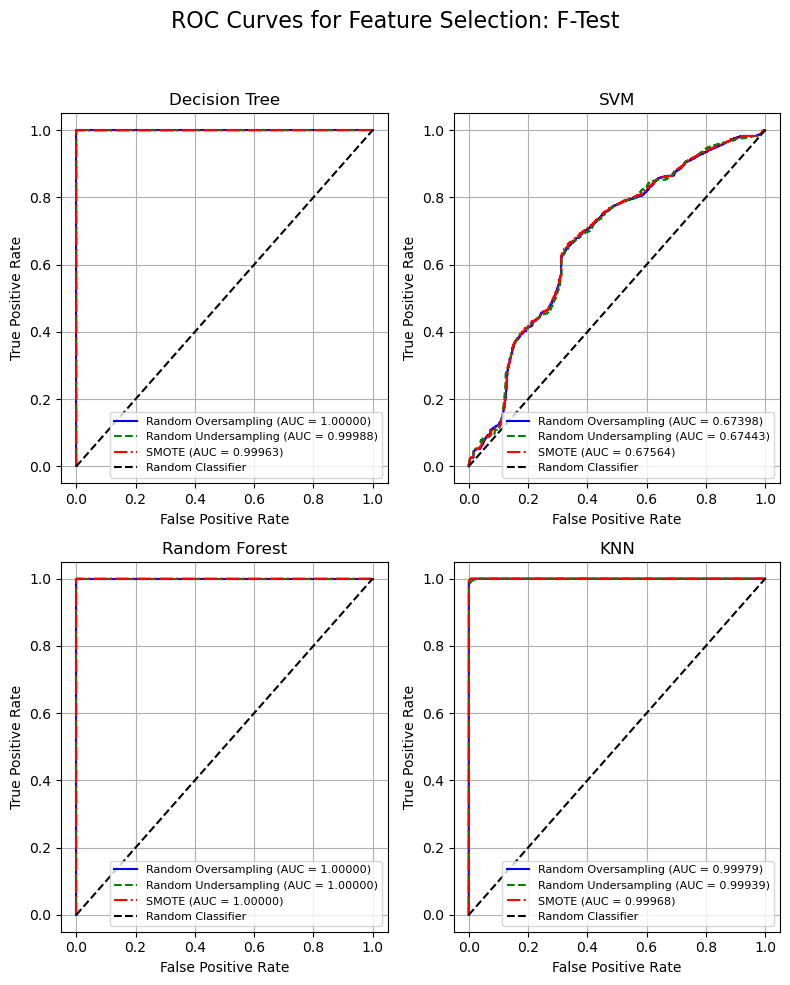

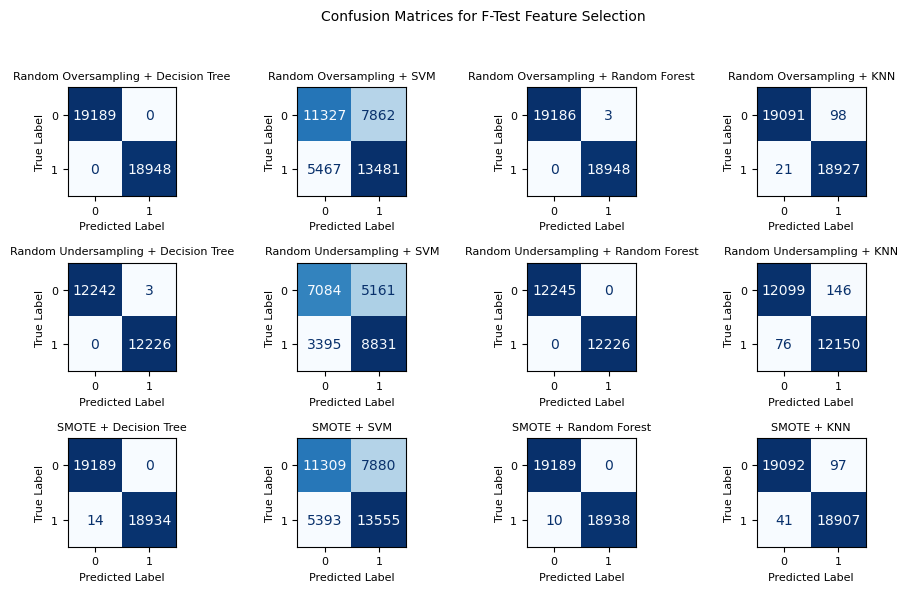

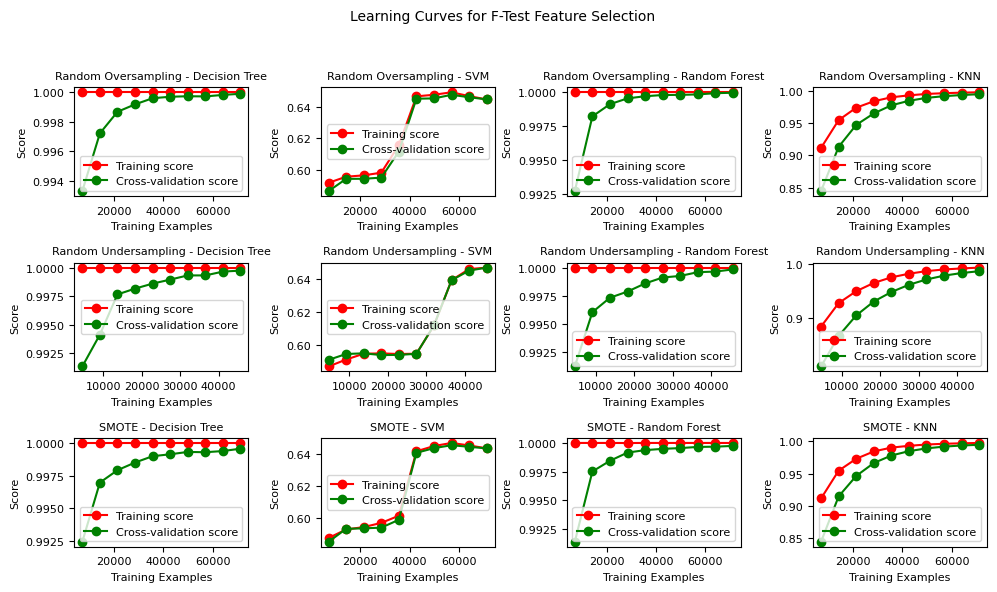

In [213]:
draw_roc_curves_for_method("F-Test")
# Call the function to draw confusion matrices for the F-Test feature selection method
plot_confusion_matrices('F-Test')
plot_learning_curves('F-Test')

In [218]:
# Since Mutual Inforamtion perform well with SMOTE Class Balancing Technique For Random Forest
# Will use this to create model to predict for new data (for creating webapplication for prediction)

# Fit the scaler on the top features (selected by Mutual Information)
scaler.fit(df[top_features_mi])

# Apply class balancing using SMOTE to handle the class imbalance in the dataset
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X[top_features_mi], y)


# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

# Train the Random Forest model on the training set
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)

# Evaluate the model's performance on the test set using various metrics like precision, recall, and F1-score
y_pred = best_model.predict(X_test)
print(f"Classification report for Random Forest with Mutual Information and SMOTE:")
print(classification_report(y_test, y_pred))

# Save the trained Random Forest model to a .pkl file for future use (e.g., in a web application)
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Save the trained scaler to a .pkl file to ensure that new data is scaled consistently during prediction
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Save the label encoders used for encoding the categorical variables to a .pkl file
# This ensures that new categorical data will be encoded in the same way during prediction
with open('label_encoders.pkl', 'wb') as le_file:
    pickle.dump(label_encoders, le_file)

Classification report for Random Forest with Mutual Information and SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19189
           1       1.00      1.00      1.00     18948

    accuracy                           1.00     38137
   macro avg       1.00      1.00      1.00     38137
weighted avg       1.00      1.00      1.00     38137

